In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime as dt,timedelta
import sys,os,glob
import matplotlib.image as mpimg

In [2]:
indir_mtpw = '/Users/bfildier/Data/satellite/MIMIC-TPW2/data/'
indir_goespw = '/Users/bfildier/Data/satellite/GOES-PW/'
indir_sonde_qrad = '/Users/bfildier/Data/EUREC4A/merged/radiative_profiles'

In [55]:
scriptdir = os.getcwd()
repodir = os.path.dirname(scriptdir)
moviedir = os.path.join(repodir,'movies')
os.makedirs(moviedir,exist_ok=True)

In [3]:
day = '20200126'
date = dt.strptime(day,'%Y%m%d')

lat_box = 11,16
lon_box = -60,-52

# Load data

## Sonde profiles

In [4]:
print('load rad profiles')
radprf = xr.open_dataset(os.path.join(indir_sonde_qrad,'rad_profiles_CF.nc'))

load rad profiles


In [5]:
radprf_day = radprf.where(radprf.z_min<=50,drop=True).sel(launch_time=day)

In [6]:
# print('convert times to datetime objects')
# timestamps = [int(lt/1e9) for lt in radprf.launch_time.values]
# times = [dt.fromtimestamp(ts)-timedelta(hours=1) for ts in timestamps] # removing 1 hour apparently necessary to match the original sonde time
# # double check that (t-dt(1970,1,1)).total_seconds() gives the same time stamp
# radprf = radprf.assign(launch_time=times) # reassign to object

## GOES images

In [7]:
indir_goes_images = '/Users/bfildier/Data/satellite/GOES/images/%s'%date.strftime('%Y_%m_%d')

In [8]:
print('load GOES images')
image_files = glob.glob(os.path.join(indir_goes_images,'*C02*00.jpg'))
image_files.sort()

images = []
for i in range(len(image_files)):
    images.append(mpimg.imread(image_files[16]))

load GOES images


## PW data

### From MIMIC

In [9]:
print('load pw data')
pw_mimic_files = glob.glob(os.path.join(indir_mtpw,'*comp%s.??????.nc'%date))
pw_mimic_files.sort()


load pw data


In [10]:
print('load and concatenate all MIMIC TPW files for that day')

# reference day time at the beginning of the year
day_ref = dt(2020,1,1)

all_pws = []

for pw_file in pw_mimic_files:

    pw_new = xr.open_dataset(pw_file)
    pw_new = pw_new.set_coords(['lonArr','latArr'])
    pw_new = pw_new.rename({'lonArr':'lon','latArr':'lat'})
    
    day_stamp = pw_file.split('.')[0][-8:]
    time_stamp = pw_file.split('.')[1]
    hour = (dt.strptime(time_stamp,'%H%M%S') - dt(1900, 1, 1))
    daytime = day + hour
    # time value to store in concatenated xarray
    total_seconds = int((daytime - day_ref).total_seconds())
    # expand dims to time dimension with new value
    pw_new = pw_new.expand_dims({'time':1})
    pw_new = pw_new.assign_coords({'time':[total_seconds]})
    # store
    all_pws.append(pw_new)
    
pw_mimic = xr.concat(all_pws,'time')

load and concatenate all MIMIC TPW files for that day


ValueError: must supply at least one object to concatenate

### From GOES

In [11]:
use_test_files = False
if use_test_files:

    pw_goes_files = glob.glob(os.path.join(indir_goespw,'00[2-5]/*.nc'))
    pw_goes_files.sort()

    pw_file = pw_goes_files[0]
    pw_subdir = pw_file.split('/')[-2]


In [12]:
pw_goes_files = glob.glob(os.path.join(indir_goespw,day,'*.nc'))
pw_goes_files.sort()

In [13]:
print('load and concatenate all GOES TPW files for that day')

pw_goes_all = []

for pw_file in pw_goes_files:

    pw_new = xr.open_dataset(pw_file)
    pw_goes_all.append(pw_new)



load and concatenate all GOES TPW files for that day


In [14]:
## concatenate
pw_goes = xr.concat(pw_goes_all,dim='t')

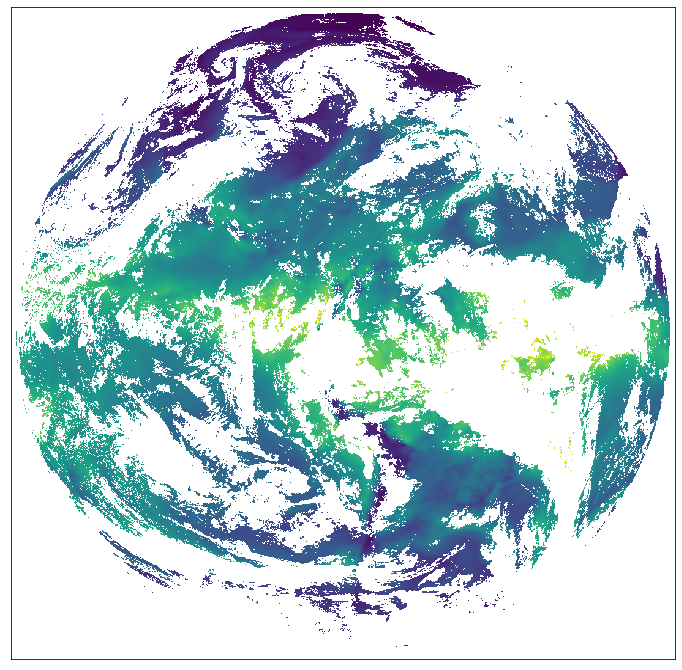

In [40]:
##-- code structures found here: https://github.com/blaylockbk/pyBKB_v2/blob/master/BB_goes16/mapping_GOES16_data.ipynb
##-- detail on all angles: https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm

from mpl_toolkits.basemap import Basemap
from pyproj import Proj

##-- satellite info

# Satellite height
sat_h = pw_goes.nominal_satellite_height[0].data*1e3 # in km

# Satellite longitude
sat_lon = pw_goes.nominal_satellite_subpoint_lon[0].data

# # Satellite sweep
# sat_sweep = C.variables['goes_imager_projection'].sweep_angle_axis

##-- longitude and latitude

p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep='x')

# The projection x and y coordinates equals
# the scanning angle (in radians) multiplied by the satellite height (http://proj4.org/projections/geos.html)
X = pw_goes.variables['x'][:] * sat_h
Y = pw_goes.variables['y'][:] * sat_h

XX, YY = np.meshgrid(X, Y)
lons, lats = p(XX, YY, inverse=True)

lats[np.isnan(values)] = np.nan
lons[np.isnan(values)] = np.nan
# ^ Please take a moment and appreciate those two lines. Before adding this seemingly simple and unimportant step,

lon_lims = np.nanmin(lons),np.nanmax(lons)
lat_lims = np.nanmin(lats),np.nanmax(lats)
        
# The geostationary projection is perhaps the easiest way to plot the image on a map.
# Essentially, we are stretching the image across a map with the same projection and dimensions.
m = Basemap(projection='geos', lon_0=sat_lon,
            resolution='i', area_thresh=10000,
            rsphere=(6378137.00,6356752.3142), 
            satellite_height=sat_h,
            llcrnrx=lon_lims[0],llcrnry=lat_lims[0],
            urcrnrx=lon_lims[1],urcrnry=lat_lims[1])

##-- show specific time slice

i_t = 3

values = pw_goes.TPW.data[i_t]

# Draw
fig,ax = plt.subplots(figsize=[15, 12])
m.imshow(np.flipud(values)) # Remember, "images" are upside down, so flip up/down
m.drawcoastlines()
m.drawcountries()
m.drawstates()

In [34]:
np.nanmin(lats), np.nanmax(lats), np.nanmin(lons), np.nanmax(lons)

(-69.41707642399932, 70.77760445519411, -147.1909942765744, -4.33696429245927)

In [41]:
def getSatelliteInfo(geos_data):
    
    ##-- satellite info

    # Satellite height
    sat_h = geos_data.nominal_satellite_height[0].data*1e3 # in km

    # Satellite longitude
    sat_lon = geos_data.nominal_satellite_subpoint_lon[0].data

    # # Satellite sweep
    # sat_sweep = C.variables['goes_imager_projection'].sweep_angle_axis

    ##-- longitude and latitude

    p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep='x')

    # The projection x and y coordinates equals
    # the scanning angle (in radians) multiplied by the satellite height (http://proj4.org/projections/geos.html)
    X = geos_data.variables['x'][:] * sat_h
    Y = geos_data.variables['y'][:] * sat_h

    XX, YY = np.meshgrid(X, Y)
    lons, lats = p(XX, YY, inverse=True)

    lats[np.isnan(values)] = np.nan
    lons[np.isnan(values)] = np.nan
    # ^ Please take a moment and appreciate those two lines. Before adding this seemingly simple and unimportant step,
    
    return sat_h, sat_lon, lons, lats

def initBasemap(sat_h, sat_lon, lons, lats):
    
    # The geostationary projection is perhaps the easiest way to plot the image on a map.
    # Essentially, we are stretching the image across a map with the same projection and dimensions.
    m = Basemap(projection='geos', lon_0=sat_lon,
                resolution='i', area_thresh=10000,
                rsphere=(6378137.00,6356752.3142), 
                satellite_height=sat_h,
                llcrnrx=np.nanmin(lons),llcrnry=np.nanmin(lats),
                urcrnrx=np.nanmax(lons),urcrnry=np.nanmax(lats))
    
    return m



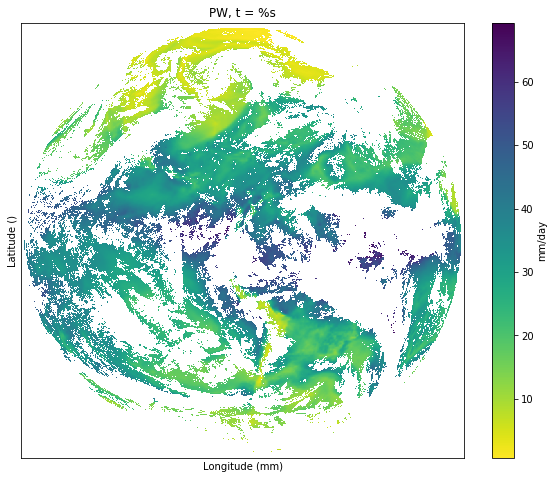

In [44]:
##-- plot functions

def showData(ax,m,i_t):


    ##-- show specific time slice

    i_t = 3

    values = pw_goes.TPW.data[i_t]

    # Draw
    h = m.imshow(np.flipud(values),cmap=cmap_PW) # Remember, "images" are upside down, so flip up/down
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()

    ax.set_xlabel('Longitude (mm)')
    ax.set_ylabel('Latitude ()')
    ax.set_title(r'PW, t = %s')

    return h


##--- main 

from matplotlib import animation

time_ref = pw_goes.t
# time_range = 

i_tmin = 0
i_tmax = len(time_ref)


# colors
cmap_PW = plt.cm.viridis_r

##-- Initialize plot

fig,ax = plt.subplots(figsize=[10, 8])

# satellite info
sat_h, sat_lon, lons, lats = getSatelliteInfo(pw_goes)

# basemap
m = initBasemap(sat_h, sat_lon, lons, lats)

# show first frame
i_t = i_tmin
h = showData(ax,m,i_t)

cbar = plt.colorbar(h,ax=ax)
cbar.set_label('mm/day')

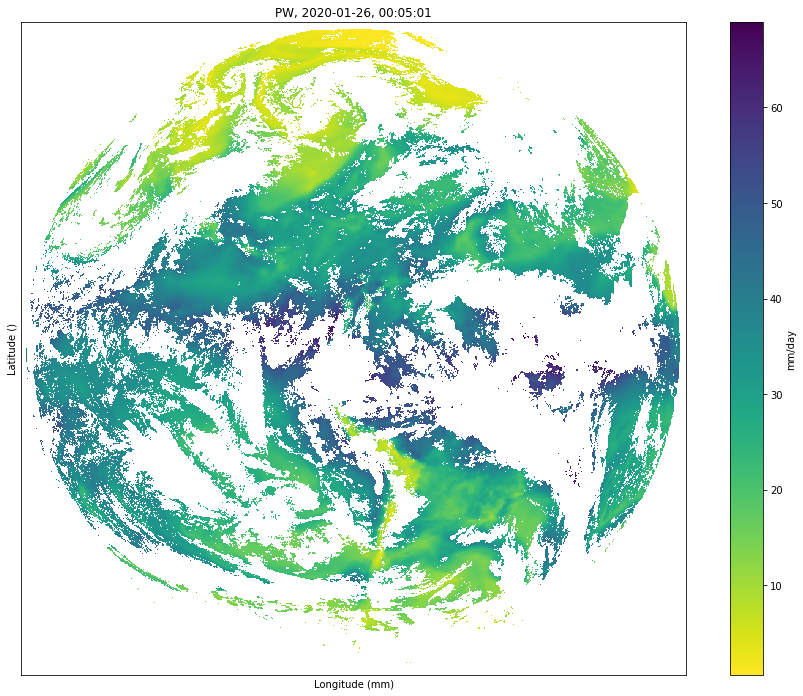

In [79]:

##-- plot functions

def showData(ax,m,i_t):

    ##-- show specific time slice

    values = pw_goes.TPW.data[i_t]

    # Draw
    h = m.imshow(np.flipud(values),cmap=cmap_PW) # Remember, "images" are upside down, so flip up/down
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()

    ax.set_xlabel('Longitude (mm)')
    ax.set_ylabel('Latitude ()')
    ax.set_title(r'PW, %s'%str(time_ref[i_t].dt.strftime('%Y-%m-%d, %H:%M:%S').values))

    return h


##--- main 

from matplotlib import animation

time_ref = pw_goes.t
# time_range = 

i_tmin = 0
i_tmax = len(time_ref)


# colors
cmap_PW = plt.cm.viridis_r

##-- Initialize plot

fig,ax = plt.subplots(figsize=[15, 12])

# satellite info
sat_h, sat_lon, lons, lats = getSatelliteInfo(pw_goes)

# basemap
m = initBasemap(sat_h, sat_lon, lons, lats)

# show first frame
i_t = i_tmin
h = showData(ax,m,i_t)

cbar = plt.colorbar(h,ax=ax)
cbar.set_label('mm/day')


##-- loop function to animate

def update(i_t):

    ##--- (a) PW(x,y)

    ax.cla()
    showData(ax,m,i_t)

##-- animate

# # shift figure to the left for display
# fig.tight_layout(h_pad=0.5)

anim = animation.FuncAnimation(fig, update,
                               frames=range(i_tmin,i_tmax), interval=200, blit=False)

writer = animation.writers['ffmpeg'](fps=3)
# mywriter = animation.FFMpegWriter(fps=3, extra_args=['-vcodec', 'libx264'])

#     anim.save(movie_path,writer=writer,savefig_kwargs={'bbox_inches':'tight'})

movie_path = os.path.join(moviedir,'GOES-TPW_%s.mp4'%day)
anim.save(movie_path,writer=writer)

plt.show()



## @ Barbados?

In [84]:
def getSatelliteInfo(geos_data):
    
    ##-- satellite info

    # Satellite height
    sat_h = geos_data.nominal_satellite_height[0].data*1e3 # in km

    # Satellite longitude
    sat_lon = geos_data.nominal_satellite_subpoint_lon[0].data

    # # Satellite sweep
    # sat_sweep = C.variables['goes_imager_projection'].sweep_angle_axis

    ##-- longitude and latitude

    p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep='x')

    # The projection x and y coordinates equals
    # the scanning angle (in radians) multiplied by the satellite height (http://proj4.org/projections/geos.html)
    X = geos_data.variables['x'][:] * sat_h
    Y = geos_data.variables['y'][:] * sat_h

    XX, YY = np.meshgrid(X, Y)
    lons, lats = p(XX, YY, inverse=True)

    lats[np.isnan(values)] = np.nan
    lons[np.isnan(values)] = np.nan
    # ^ Please take a moment and appreciate those two lines. Before adding this seemingly simple and unimportant step,
    
    return sat_h, sat_lon, lons, lats

def initBasemap(sat_h, sat_lon,lons,lats,lon_lims=None,lat_lims=None):
    
    # box range
    if lon_lims is None:
        lon_lims = np.nanmin(lons),np.nanmax(lons)
    if lat_lims is None:
        lat_lims = np.nanmin(lats),np.nanmax(lats)
        
    # The geostationary projection is perhaps the easiest way to plot the image on a map.
    # Essentially, we are stretching the image across a map with the same projection and dimensions.
    m = Basemap(projection='geos', lon_0=sat_lon,
                resolution='i', area_thresh=10000,
                rsphere=(6378137.00,6356752.3142), 
                satellite_height=sat_h,
                llcrnrx=lon_lims[0],llcrnry=lat_lims[0],
                urcrnrx=lon_lims[1],urcrnry=lat_lims[1])
    
    return m



In [112]:
values_1D

numpy.ndarray

<xarray.Variable (x: 1086)>
array([-5435897. , -5425877. , -5415856.5, ...,  5415857. ,  5425877. ,
        5435898. ], dtype=float32) <xarray.Variable (y: 1086)>
array([ 5435897. ,  5425877. ,  5415856.5, ..., -5415857. , -5425877. ,
       -5435898. ], dtype=float32)


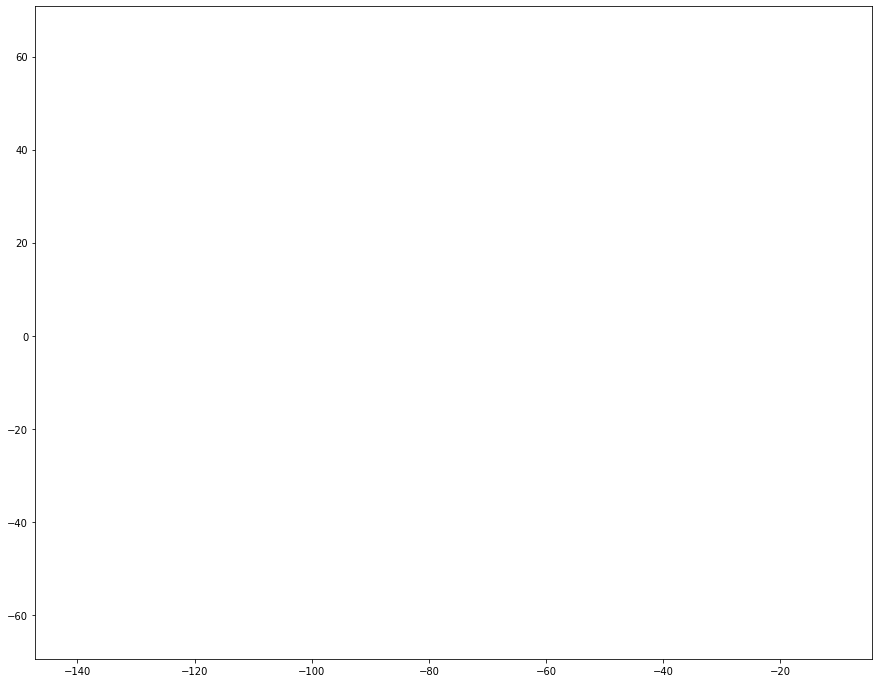

In [113]:
## try to plot barbados region only, 1 snapshot

import numpy.ma as ma

values = pw_goes.TPW.data[0]
values_m = ma.masked_where(np.isnan(values),values)

lon_lims = -60,-52
lat_lims = 11,16

# The projection x and y coordinates equals
# the scanning angle (in radians) multiplied by the satellite height (http://proj4.org/projections/geos.html)
X = pw_goes.variables['x'][:] * sat_h
Y = pw_goes.variables['y'][:] * sat_h

XX, YY = np.meshgrid(X, Y)
lons, lats = p(XX, YY, inverse=True)

mask_valid = np.logical_not(np.isnan(values))
lons_1D = lons[mask_valid]
lats_1D = lats[mask_valid]
values_1D = values[mask_valid]

# lats[np.isinf(lats)] = np.nan
# lons[np.isinf(lons)] = np.nan
# # ^ Please take a moment and appreciate those two lines. Before adding this seemingly simple and unimportant step,


# Make a new map object for the HRRR model domain map projection
mH = Basemap(resolution='i', projection='lcc', area_thresh=5000, \
             width=1800*3000, height=1060*3000, \
             lat_1=38.5, lat_2=38.5, \
             lat_0=38.5, lon_0=-97.5)

# Now we can plot the GOES data on the HRRR map domain and projection
plt.figure(figsize=[15, 12])

plt.pcolormesh(lons_1D,lats_1D,values_1D)

# # The values of R are ignored becuase we plot the color in colorTuple, but pcolormesh still needs its shape.
# newmap = mH.pcolormesh(lons, lats, values_m, linewidth=0, latlon=True)
# newmap.set_array(None) # without this line the linewidth is set to zero, but the RGB colorTuple is ignored. I don't know why.


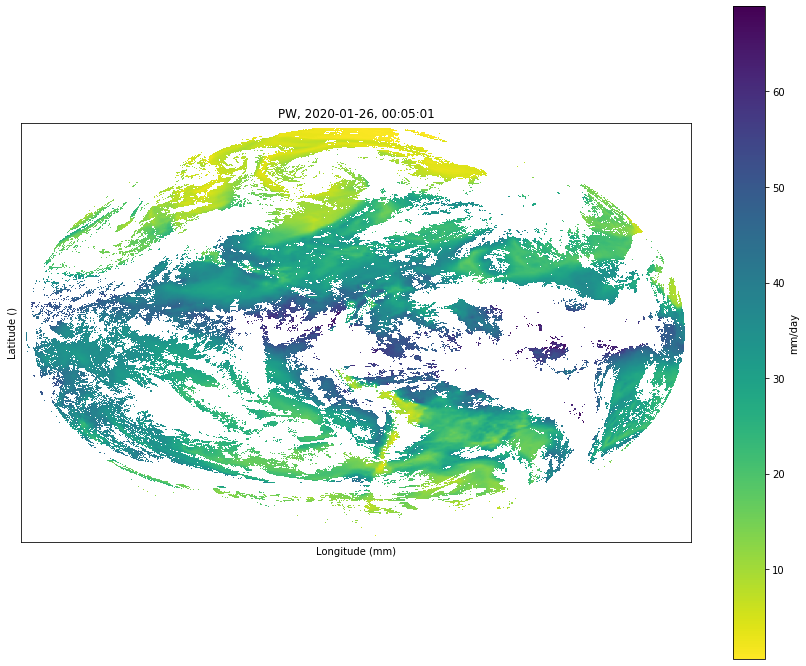

In [85]:


##-- plot functions

def showData(ax,m,i_t):

    ##-- show specific time slice

    values = pw_goes.TPW.data[i_t]

    # Draw
    h = m.imshow(np.flipud(values),cmap=cmap_PW) # Remember, "images" are upside down, so flip up/down
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()

    ax.set_xlabel('Longitude (mm)')
    ax.set_ylabel('Latitude ()')
    ax.set_title(r'PW, %s'%str(time_ref[i_t].dt.strftime('%Y-%m-%d, %H:%M:%S').values))

    return h


##--- main 

from matplotlib import animation

time_ref = pw_goes.t
# time_range = 

i_tmin = 0
i_tmax = len(time_ref)


# colors
cmap_PW = plt.cm.viridis_r

##-- Initialize plot

fig,ax = plt.subplots(figsize=[15, 12])

# satellite info
sat_h, sat_lon, lons, lats = getSatelliteInfo(pw_goes)

# basemap
m = initBasemap(sat_h, sat_lon, lons, lats, lon_box, lat_box)

# show first frame
i_t = i_tmin
h = showData(ax,m,i_t)

cbar = plt.colorbar(h,ax=ax)
cbar.set_label('mm/day')


##-- loop function to animate

def update(i_t):

    ##--- (a) PW(x,y)

    ax.cla()
    showData(ax,m,i_t)

##-- animate

# # shift figure to the left for display
# fig.tight_layout(h_pad=0.5)

anim = animation.FuncAnimation(fig, update,
                               frames=range(i_tmin,i_tmax), interval=200, blit=False)

writer = animation.writers['ffmpeg'](fps=3)
# mywriter = animation.FFMpegWriter(fps=3, extra_args=['-vcodec', 'libx264'])

#     anim.save(movie_path,writer=writer,savefig_kwargs={'bbox_inches':'tight'})

movie_path = os.path.join(moviedir,'GOES-TPW_BBD_%s.mp4'%day)
anim.save(movie_path,writer=writer)

plt.show()



# From MIMIC

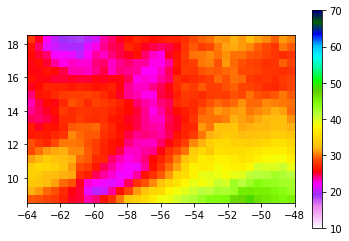

In [8]:
lat_inds = np.logical_and(pw.lat >= lat_box[0],pw.lat <= lat_box[1])
lon_inds = np.logical_and(pw.lon >= lon_box[0],pw.lon <= lon_box[1])

i_time = 15
# cmap = 'nipy_spectral_r'
# cmap = 'gist_stern_r'
# cmap = 'bone_r'
# cmap = 'magma_r'
cmap = 'gist_ncar_r'

dx = (lon_box[1]-lon_box[0])/2.
dy = (lat_box[1]-lat_box[0])/2.
extent = [lon_box[0]-dx, lon_box[-1]+dx, lat_box[0]-dy, lat_box[-1]+dy]

h = plt.imshow(pw.tpwGrid[i_time,lat_inds,lon_inds],
            origin='lower',
            extent=extent,
            cmap=cmap,
            vmin=10,vmax=70)
plt.colorbar(h)

In [39]:
print("calculate pw for each sonde")

# mask_40m = radprf.z_min <= 40

q = radprf.h2o[mask_40m]
plev = radprf.plev[mask_40m]
dplev = -np.diff(plev,axis=1)
pw = (q*dplev/9.81).sum(axis=1)

calculate pw for each sonde


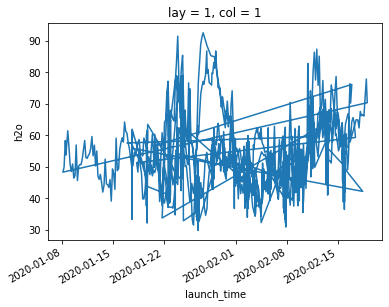

In [41]:
pw.plot()